In [1]:
# Continuacion ejemplo de prediccion precios de cierre del bitcoin con LSTM
# Se cargan los mismos paquetes y el pre-procesamiento es exactamente el mismo que antes.

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten, SimpleRNN

# en jupyter lab online cargamos con tensorflow
#import tensorflow as tf
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten, SimpleRNN

Using TensorFlow backend.
/Users/MAValle/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/MAValle/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/MAValle/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/MAValle/anaconda3/lib/python3.7/site-packag

In [2]:
# carga de datos
data = pd.read_csv("data_bitcoin.csv") # son app 63Kb de datos.
data.head()

,Price
0,5.874167
1,5.582143
2,5.120000
3,4.835000
4,4.870000


In [3]:
data.shape

(3448, 1)

In [4]:
# El objetivo es hacer una prediccion de los precios diarios de cierre. 
# consideraremos los últimos 60 precios para el testeo.

close_train = data.iloc[:len(data)-60]
close_test  = data.iloc[len(close_train):]

print(close_test.head())
print(close_train.shape)
print(close_test.shape)

             Price
3388  34793.749638
3389  34694.376658
3390  38636.764980
3391  37039.937682
3392  36841.820185
(3388, 1)
(60, 1)


In [5]:
# Aqui transformamos los valores entre 0-1 para estandarizar.

# convertir a array
close_train = np.array(close_train)
close_train = close_train.reshape(close_train.shape[0],1) # convierte close_train en un array de 3388 filas y 1 columna
print(close_train)
#print(close_train.shape[0])

[[5.87416667e+00]
 [5.58214286e+00]
 [5.12000000e+00]
 ...
 [4.04054990e+04]
 [3.89682115e+04]
 [3.36545416e+04]]


In [6]:
# estandarizar
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close_train)
print(close_scaled)

[[8.99473645e-05]
 [8.27196354e-05]
 [7.12813785e-05]
 ...
 [1.00000000e+00]
 [9.64426445e-01]
 [8.32910571e-01]]


In [7]:
# utiliza 60 datos como set de entrenamiento y entrada, y luego la 61 es el valor a predecir.

timestep=60
x_train=[]
y_train=[]

#close_scaled.shape[0]  es el largo de la serie igual a 3388

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])


#print(x_train) # tiene 3388 vectores de 60 precios
print(len(x_train))
#print(y_train) # tiene 3388 precios
print(len(y_train))

#y_train[0]
x_train[0]

3328
3328


array([8.99473645e-05, 8.27196354e-05, 7.12813785e-05, 6.42274921e-05,
       6.50937588e-05, 6.43512445e-05, 6.58362732e-05, 7.84153400e-05,
       8.62801686e-05, 8.54881533e-05, 8.58841609e-05, 8.62200603e-05,
       9.42993236e-05, 9.07217545e-05, 6.52175112e-05, 6.50584010e-05,
       6.37737333e-05, 6.45574985e-05, 6.54959541e-05, 7.27994079e-05,
       6.61368147e-05, 6.02497366e-05, 5.43273006e-05, 4.08382898e-05,
       5.10354870e-05, 4.41177282e-05, 4.22738175e-05, 4.23480690e-05,
       4.47983664e-05, 4.15808041e-05, 3.96007658e-07, 0.00000000e+00,
       1.76965922e-05, 1.12202170e-05, 1.31177537e-05, 4.25089471e-05,
       4.50046203e-05, 3.20271194e-05, 2.57758556e-05, 2.68542693e-05,
       2.72930278e-05, 2.15329164e-05, 1.75728398e-05, 2.07904021e-05,
       2.43049700e-05, 2.45339120e-05, 2.62355074e-05, 2.74730313e-05,
       2.74730313e-05, 1.08572100e-05, 1.55928015e-05, 1.27464965e-05,
       1.25608679e-05, 8.22953415e-06, 5.50698150e-06, 3.21756222e-06,
      

In [8]:
# paso 2
x_train,y_train = np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x-train-shape= ",x_train.shape)
print("y-train-shape= ",y_train.shape)

x-train-shape=  (3328, 60, 1)
y-train-shape=  (3328,)


In [9]:
# notar la estructura de x_train:

# por ejemplo x_train.shape[1] es un array con 60 columnas. Estas columnas son las
#que van a entrar al input layer. No entra un vector numérico. 
# esto es importante porque condiciona la forma en que salen los ouputs.

print(x_train.shape) # tenemos 3328 vectores de 60 precios. Esto es lo que va entrando a la red.
print(x_train.shape[1]) # cada vector tiene 60 precios.

(3328, 60, 1)
60


In [10]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [11]:
# Implementacion de LSTM


modell = Sequential()
modell.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#modell.add(Dropout(0.2))
modell.add(LSTM(100, return_sequences=False))
#modell.add(Dropout(0.2))
modell.add(Dense(1))

#igual que antes
modell.compile(loss="mean_squared_error",optimizer="rmsprop")
modell.fit(x_train,y_train,epochs= 50,batch_size=64)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
3328/3328 [==============================] - 18s 5ms/step - loss: 0.0019
Epoch 2/50
3328/3328 [==============================] - 14s 4ms/step - loss: 6.7150e-04
Epoch 3/50
3328/3328 [==============================] - 13s 4ms/step - loss: 4.5240e-04
Epoch 4/50
3328/3328 [==============================] - 14s 4ms/step - loss: 3.7326e-04
Epoch 5/50
3328/3328 [==============================] - 14s 4ms/step - loss: 3.5398e-04
Epoch 6/50
3328/3328 [==============================] - 14s 4ms/step - loss: 2.8681e-04
Epoch 7/50
3328/3328 [==============================] - 14s 4ms/step - loss: 2.9388e-04
Epoch 8/50
3328/3328 [==============================] - 14s 4ms/step - loss: 2.2910e-04
Epoch 9/50
3328/3328 [==============================] - 14s 4ms/step - loss: 1.8416e-04
Epoch 10/50
3328/3328 [==============================] - 14s 4ms/step - loss: 2.1907e-04
Epo

In [12]:
# ahora preparamos data de test para prediccion. IGUAL QUE ANTES!!!
# recordemos que en close_test tenemos nuestros datos para el testeo!

# len(data) - len(close_test)# = 3388  datos de entrenamiento 
# len(data) - len(close_test) - timestep = 3328. tomaremos para prediccion desde el dato 3328 
# hasta el ultimo quedando en 120 valores. Tomamos 60 de entrenamiento y otros 60 del test.
# Esto lo dejaremos en input.
# ¿por que?  porque si queremos 60 predicciones con 60 datos de entrada, necesitamos al menos
# el doble de datos.

inputs=data[len(data)-len(close_test)-timestep:]


inputs=inputs.values.reshape(-1,1) # convierte inputs a array de 120 filas y 1 columna 
print(inputs.shape)
print(inputs)
inputs=scaler.transform(inputs) # escala valores 0-1.

(120, 1)
[[16279.82971834]
 [16002.77983225]
 [15979.96787722]
 [16430.74588307]
 [17268.94039002]
 [17881.21028309]
 [17801.6469543 ]
 [18360.23015132]
 [18720.46861578]
 [18337.80238069]
 [18438.878714  ]
 [18939.28873823]
 [19051.71350101]
 [17200.67461348]
 [16955.0982882 ]
 [17389.9772657 ]
 [18027.70585954]
 [19061.8357438 ]
 [19196.46453403]
 [18933.50034101]
 [19309.47116477]
 [19081.52631458]
 [18981.5437042 ]
 [19150.4708231 ]
 [19189.08096393]
 [18865.08550867]
 [18244.81628606]
 [18273.61070645]
 [17923.9118587 ]
 [18479.16546148]
 [19142.26171027]
 [19166.1507658 ]
 [19335.52610827]
 [20378.55465055]
 [22730.73493971]
 [22865.0388434 ]
 [23458.76198432]
 [23603.69759416]
 [23078.46686784]
 [23129.09807163]
 [23483.56654105]
 [23203.45488959]
 [24075.884614  ]
 [25594.26362466]
 [27094.35316904]
 [26963.03143607]
 [26654.23907847]
 [28180.26608524]
 [28835.9243266 ]
 [29269.12533855]
 [31247.50621825]
 [33477.30571855]
 [31286.55592198]
 [32372.35450507]
 [34957.00203889]
 

In [13]:
# paso 2 IGUAL QUE ANTES!!
# al igual que con x_train, tenemos que generar del set de datos de input, aquellas muestras 
# que seran de entrada para hacer la prediccion. Obviamente, en bloques de 60.


x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

print(x_test.shape) #60 vectores con 60 valores de entrada para la prediccion.
print(x_test)

(60, 60, 1)
[[[0.40287814]
  [0.39602102]
  [0.39545641]
  ...
  [1.        ]
  [0.96442644]
  [0.83291057]]

 [[0.39602102]
  [0.39545641]
  [0.40661338]
  ...
  [0.96442644]
  [0.83291057]
  [0.86110652]]

 [[0.39545641]
  [0.40661338]
  [0.4273591 ]
  ...
  [0.83291057]
  [0.86110652]
  [0.85864699]]

 ...

 [[1.        ]
  [0.96442644]
  [0.83291057]
  ...
  [1.24625283]
  [1.25827194]
  [1.33648419]]

 [[0.96442644]
  [0.83291057]
  [0.86110652]
  ...
  [1.25827194]
  [1.33648419]
  [1.37531074]]

 [[0.83291057]
  [0.86110652]
  [0.85864699]
  ...
  [1.33648419]
  [1.37531074]
  [1.39307122]]]


In [15]:
#predicciones

predicted_data=modell.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

print(predicted_data)

[[30978.488]
 [37105.02 ]
 [34488.926]
 [41731.035]
 [35125.082]
 [37738.3  ]
 [34515.754]
 [37319.26 ]
 [37269.582]
 [34104.258]
 [31891.121]
 [32041.008]
 [33487.152]
 [32429.807]
 [34732.832]
 [31326.033]
 [31178.812]
 [32945.82 ]
 [37487.516]
 [32727.02 ]
 [33790.37 ]
 [34119.406]
 [35699.613]
 [37627.516]
 [37654.223]
 [37780.145]
 [41026.71 ]
 [37138.016]
 [46070.86 ]
 [47150.4  ]
 [43435.918]
 [47137.58 ]
 [46650.707]
 [46035.113]
 [49194.293]
 [45277.754]
 [49919.96 ]
 [50926.293]
 [50842.53 ]
 [53717.46 ]
 [55902.594]
 [55102.37 ]
 [49197.863]
 [44925.195]
 [51833.83 ]
 [48257.293]
 [44380.996]
 [48245.727]
 [42287.766]
 [51430.7  ]
 [46783.266]
 [52320.043]
 [45935.656]
 [46871.99 ]
 [48169.5  ]
 [50997.67 ]
 [49601.633]
 [55342.227]
 [53797.785]
 [54998.746]]


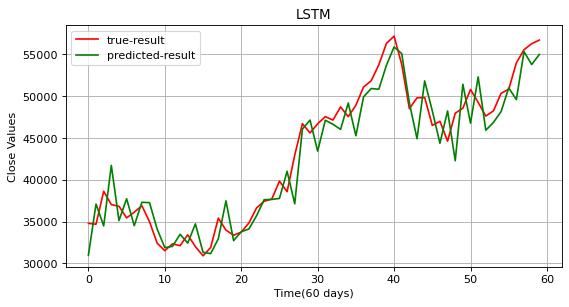

In [16]:
# para ploteo
data_test = np.array(close_test)
data_test = data_test.reshape(len(data_test),1)

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true-result")
plt.plot(predicted_data,color="g",label="predicted-result")
plt.legend()
plt.title("LSTM")
plt.xlabel("Time(60 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [17]:
# Como hacemos para ver la evolucion del MSE (loss function) con el set de test?

#print(data_test.shape)  # (60, 1)
#print(predicted_data.shape) # (60, 1)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_test, predicted_data)

print(mse)


#recordar que con RNN da app 5,378,022.8

6130660.176734936


In [ ]:
# Puede suceder que el resultado sea similar al de la RNN. En este caso, conviene cambiar algunos valores de 
# los hiperparámetros con diferentes ioptimizadores (Adam, SDG, etc.) para ver si hay cambios. 

# Tambièn podemos incrementar el número de capas LSTM y verificar.

# Algo a tener en cuenta, que en rigor para comparar modelos, es necesario repetarlo un buen número de veces
# y promediar la resultados. 

# La estructura de este código puede servir tambièn para otras series de tiempo.